In [1]:
from import_helm_lite import read_helm_list
from helper_functions import calculate_stats, num_words, rank_questions
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

# Preliminary test

In [2]:
df = read_helm_list(version='v1.11.0/', 
                    instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=meta_llama-3.3-70b-instruct-turbo/')
df2 = read_helm_list(version='v1.11.0/', 
                    instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=upstage_solar-pro-241126/')
df3 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=anthropic_claude-3-5-sonnet-20241022/')
df4 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=google_gemini-1.5-flash-002/')
df5 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=google_gemini-1.5-pro-002/')
df6 = read_helm_list(version='v1.10.0/',
                     instance='mmlu:subject=abstract_algebra,method=multiple_choice_joint,model=openai_gpt-4o-2024-08-06/')

In [3]:
dfs = [df, df2, df3, df4, df5, df6]

In [4]:
ranked_questions = rank_questions(dfs, metric_name='stats.exact_match', desired_stat_name='num_words')

In [16]:
ranked_questions.head()

,instance_id,input.text,predicted_text_0,stats.exact_match_0,num_words_0,predicted_text_1,stats.exact_match_1,num_words_1,predicted_text_2,stats.exact_match_2,...,predicted_text_3,stats.exact_match_3,num_words_3,predicted_text_4,stats.exact_match_4,num_words_4,predicted_text_5,stats.exact_match_5,num_words_5,std
0,id10,Statement 1 | The symmetric group S_3 is cycli...,D,1.0,22,D,1.0,22,D,1.0,...,D,1.0,22,D,1.0,22,D,1.0,22,0.0
35,id29,The polynomial x^3 + 2x^2 + 2x + 1 can be fact...,B,0.0,21,D,0.0,21,D,0.0,...,B,0.0,21,B,0.0,21,B,0.0,21,0.0
40,id34,The set of all real numbers under the usual mu...,D,1.0,17,D,1.0,17,D,1.0,...,D,1.0,17,D,1.0,17,D,1.0,17,0.0
41,id35,Statement 1| Every group of order p^2 where p ...,A,1.0,47,A,1.0,47,A,1.0,...,A,1.0,47,A,1.0,47,A,1.0,47,0.0
45,id39,The set of all nth roots of unity under multip...,D,1.0,16,D,1.0,16,D,1.0,...,D,1.0,16,D,1.0,16,D,1.0,16,0.0


Below is a dumb example of a plot because for MMLU all the model responses have 1 letter, so all the word counts (input text + output text) are the exact same

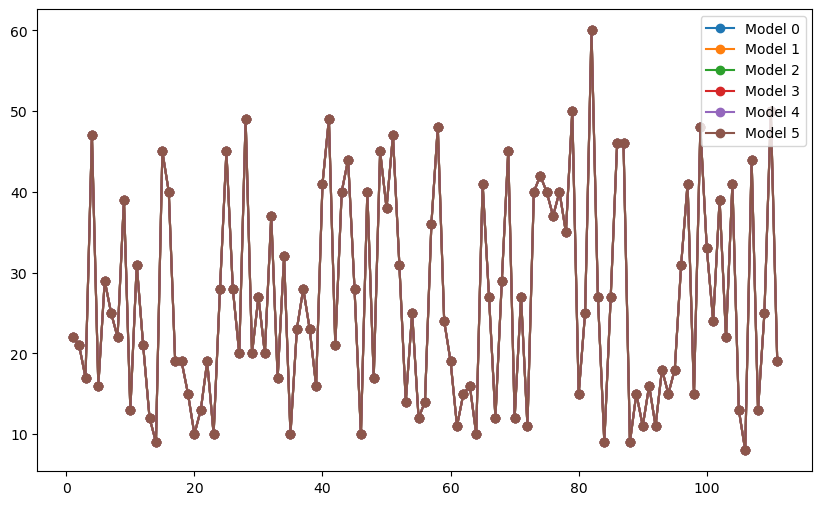

In [15]:
# Create the plot:
plt.figure(figsize=(10, 6))
x_values = range(1, ranked_questions.shape[0] + 1)  # ranking positions

# Plot word counts for each model.
for i in range(len(dfs)):
    plt.plot(x_values, ranked_questions[f'num_words_{i}'], marker='o', label=f'Model {i}')
    
plt.legend()

# Attempt to read all files in all versions

In [2]:
versions = [f'v1.{str(i)}.0/' for i in range(14)]

In [3]:
runs = '/nlp/scr4/nlp/crfm/yifanmai/helm-release/benchmark_output/runs/'

In [6]:
version = versions[0]
for instance_df in os.listdir(runs + version):
        if instance_df == 'eval_cache':
            continue
        print(instance_df)
        break

legalbench:subset=international_citizenship_questions,model=tiiuae_falcon-7b


In [12]:
# First, let's extract benchmark from instance string
def get_benchmark(instance_string):
    # Split on 'model=' and take everything before it
    return instance_string.split('model=')[0].strip(',')

def get_model_from_instance(instance_string):
    if 'model=' in instance_string:
        return instance_string.split('model=')[1].split(',')[0].strip()
    return None

# Group dataframes by benchmark

benchmark_to_dfs = {}
benchmark_to_model = {}  # New dictionary to store model names

for version in versions[:1]:
    for instance_df in os.listdir(runs + version):
        if instance_df == 'eval_cache':
            continue
        
        df_1 = read_helm_list(version=version, instance=instance_df + '/')
        
        benchmark = get_benchmark(instance_df)
        model = get_model_from_instance(instance_df)
        
        if benchmark not in benchmark_to_dfs:
            benchmark_to_dfs[benchmark] = []
            benchmark_to_model[benchmark] = []
        benchmark_to_dfs[benchmark].append(df_1)
        benchmark_to_model[benchmark].append(model)

# Debugging

In [5]:
metrics = [
    'stats.bleu_4',
    'stats.exact_match',
    'stats.math_equiv_chain_of_thought',
    'stats.f1_score',
    'stats.final_number_exact_match',
    'stats.quasi_exact_match'
]

In [2]:
output_dir = 'analysis_output'

BENCHMARK_MODEL_FILE = os.path.join(output_dir, 'benchmark_to_model.pkl')
RANKED_RESULTS_FILE = os.path.join(output_dir, 'ranked_results.pkl')

with open(BENCHMARK_MODEL_FILE, 'rb') as f:
            benchmark_to_model = pickle.load(f)
            
with open(RANKED_RESULTS_FILE, 'rb') as f:
            ranked_results = pickle.load(f)

In [7]:
benchmark = 'commonsense:dataset=openbookqa,method=multiple_choice_joint'
model_names = benchmark_to_model[benchmark]
ranked_df = ranked_results[benchmark]

metric_name = None
for possible_metric in metrics:
    if any(col.startswith(possible_metric) for col in ranked_df.columns):
        metric_name = possible_metric
        break
metric_name

'stats.exact_match'

In [8]:
ranked_df['agreement_level'] = pd.qcut(ranked_df['std'], 3, 
                                            labels=['High', 'Medium', 'Low'])
ranked_df.head()

,instance_id,input.text,predicted_text_0,stats.exact_match_0,num_words_0,predicted_text_1,stats.exact_match_1,num_words_1,predicted_text_2,stats.exact_match_2,...,stats.exact_match_27,num_words_27,predicted_text_28,stats.exact_match_28,num_words_28,predicted_text_29,stats.exact_match_29,num_words_29,std,agreement_level
99,id5056,Cold-blooded animals are often,D,0.0,5,D,0.0,5,D,0.0,...,0.0,5,D,0.0,5,D,0.0,5,0.000000,High
378,id5335,What could I use as biofuel,D,1.0,7,D,1.0,7,D,1.0,...,1.0,7,D,1.0,7,D,1.0,7,0.182574,High
420,id5377,DNA is a vehicle for passing,D,0.0,7,D,0.0,7,D,0.0,...,0.0,7,D,0.0,7,D,0.0,7,0.182574,High
401,id5358,"If I want to go running at night, what can I u...",B,1.0,16,B,1.0,16,B,1.0,...,1.0,16,B,1.0,16,B,1.0,16,0.182574,High
96,id5053,Rainbows are always found after what?,C,1.0,7,C,1.0,7,C,1.0,...,1.0,7,C,1.0,7,C,1.0,7,0.182574,High


In [14]:
ranked_df['agreement_level'].value_counts()

agreement_level
High      175
Low       163
Medium    162
Name: count, dtype: int64

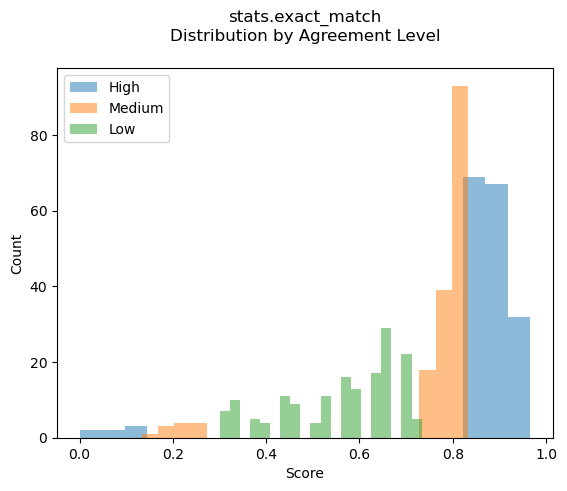

In [11]:
metric_cols = [col for col in ranked_df.columns if col.startswith(metric_name + '_')]

hist_bin_values = []
bin_edges = []

for level in ['High', 'Medium', 'Low']:
    level_df = ranked_df[ranked_df['agreement_level'] == level]
    scores = level_df[metric_cols].mean(axis=1)
    n, bins, _ = plt.hist(scores, alpha=0.5, label=level, bins=20)
    hist_bin_values.append(n)
    bin_edges.append(bins)

plt.title(f'{metric_name}\nDistribution by Agreement Level', fontsize=12, pad=20)
plt.xlabel('Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend()

In [12]:
hist_bin_values

[array([ 2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 69., 67., 32.]),
 array([ 1.,  3.,  4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., 18., 39., 93.]),
 array([ 7., 10.,  0.,  5.,  4.,  0., 11.,  9.,  0.,  4., 11.,  0., 16.,
        13.,  0., 17., 29.,  0., 22.,  5.])]

In [13]:
bin_edges

[array([0.        , 0.04833333, 0.09666667, 0.145     , 0.19333333,
        0.24166667, 0.29      , 0.33833333, 0.38666667, 0.435     ,
        0.48333333, 0.53166667, 0.58      , 0.62833333, 0.67666667,
        0.725     , 0.77333333, 0.82166667, 0.87      , 0.91833333,
        0.96666667]),
 array([0.13333333, 0.16833333, 0.20333333, 0.23833333, 0.27333333,
        0.30833333, 0.34333333, 0.37833333, 0.41333333, 0.44833333,
        0.48333333, 0.51833333, 0.55333333, 0.58833333, 0.62333333,
        0.65833333, 0.69333333, 0.72833333, 0.76333333, 0.79833333,
        0.83333333]),
 array([0.3       , 0.32166667, 0.34333333, 0.365     , 0.38666667,
        0.40833333, 0.43      , 0.45166667, 0.47333333, 0.495     ,
        0.51666667, 0.53833333, 0.56      , 0.58166667, 0.60333333,
        0.625     , 0.64666667, 0.66833333, 0.69      , 0.71166667,
        0.73333333])]

## Older debugging

In [7]:
metrics = {
        'stats.bleu_4': [],
        'stats.exact_match': [],
        'stats.math_equiv_chain_of_thought': [],
        'stats.f1_score': [],
        'stats.final_number_exact_match': [],
        'stats.quasi_exact_match': []
    }

In [11]:
benchmark_to_dfs['legalbench:subset=international_citizenship_questions'][0]

,instance_id,predicted_text,stats.num_prompt_tokens,stats.num_output_tokens,stats.inference_runtime,stats.num_train_instances,stats.prompt_truncated,stats.quasi_exact_match,references,input.text
0,id102,Yes,242.0,1.0,0.290401,4.0,0.0,1.0,"[{'output': {'text': 'Yes'}, 'tags': ['correct...",Question: Consider the country of Albania. Doe...
1,id1039,Yes,254.0,1.0,0.579707,4.0,0.0,0.0,"[{'output': {'text': 'No'}, 'tags': ['correct']}]",Question: Consider the country of Chile. Does ...
2,id1055,Yes,251.0,1.0,0.616136,4.0,0.0,1.0,"[{'output': {'text': 'Yes'}, 'tags': ['correct...",Question: Consider the country of China. Does ...
3,id1064,(a) 10 years of continuous residence in the c...,231.0,1.0,2.282338,4.0,0.0,0.0,"[{'output': {'text': 'No'}, 'tags': ['correct']}]",Question: Consider the country of China. Which...
4,id1069,Yes,250.0,1.0,0.632836,4.0,0.0,0.0,"[{'output': {'text': 'No'}, 'tags': ['correct']}]",Question: Consider the country of China. Does ...
...,...,...,...,...,...,...,...,...,...,...
995,id9295,No,274.0,1.0,0.374741,4.0,0.0,1.0,"[{'output': {'text': 'No'}, 'tags': ['correct']}]",Question: Consider the country of Zambia. Does...
996,id9303,Yes,257.0,1.0,0.784220,4.0,0.0,1.0,"[{'output': {'text': 'Yes'}, 'tags': ['correct...",Question: Consider the country of Zimbabwe. Do...
997,id942,Yes,249.0,1.0,0.328789,4.0,0.0,1.0,"[{'output': {'text': 'Yes'}, 'tags': ['correct...",Question: Consider the country of Central Afri...
998,id986,Yes,253.0,1.0,0.587906,4.0,0.0,0.0,"[{'output': {'text': 'No'}, 'tags': ['correct']}]",Question: Consider the country of Canada. Does...


In [8]:
ranked_results = {}
for benchmark, dfs in benchmark_to_dfs.items():
    
    sample_df = dfs[0]
    # Find which metric is present in this benchmark's dataframes
    metric_name = None
    for possible_metric in metrics.keys():
        if possible_metric in sample_df.columns:
            metric_name = possible_metric
            break
        
    if metric_name is None:
        print(f"Warning: No known metric found in columns for benchmark {benchmark}")
        continue
    
    ranked_results[benchmark] = rank_questions(dfs, metric_name=metric_name, desired_stat_name='num_words')

In [14]:
ranked_results['legalbench:subset=international_citizenship_questions']

,instance_id,input.text,predicted_text_0,stats.quasi_exact_match_0,num_words_0,predicted_text_1,stats.quasi_exact_match_1,num_words_1,predicted_text_2,stats.quasi_exact_match_2,...,predicted_text_27,stats.quasi_exact_match_27,num_words_27,predicted_text_28,stats.quasi_exact_match_28,num_words_28,predicted_text_29,stats.quasi_exact_match_29,num_words_29,std
351,id3816,Question: Consider the country of Malta. Does ...,Yes,0.0,35,Yes,0.0,35,Yes,0.0,...,Yes,0.0,35,Yes,0.0,35,"Yes, Malta provides for the grant of citizensh...",0.0,58,0.000000
636,id6074,Question: Consider the country of United State...,Yes,0.0,34,Yes,0.0,34,Yes,0.0,...,Yes,0.0,34,Yes,0.0,34,"Yes, the United States provides for acquisitio...",0.0,56,0.000000
25,id1242,Question: Consider the country of Colombia. Do...,Yes,0.0,43,Yes,0.0,43,Yes,0.0,...,Yes,0.0,43,Yes,0.0,43,"Yes, if the child is under 18 years old or dis...",0.0,59,0.000000
908,id847,Question: Consider the country of Brunei. Does...,No,1.0,37,No,1.0,37,No,1.0,...,No,1.0,37,No,1.0,37,No,1.0,37,0.000000
677,id6401,Question: Consider the country of Zambia. Does...,Yes,1.0,19,Yes,1.0,19,Yes,1.0,...,Yes,1.0,19,Yes,1.0,19,Yes,1.0,19,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,id5432,Question: Consider the country of Sweden. Does...,Yes,1.0,39,Yes,1.0,39,Yes,1.0,...,Yes,1.0,39,No,0.0,39,No,0.0,39,0.508548
877,id8180,Question: Consider the country of Montenegro. ...,No,0.0,51,No,0.0,51,Yes,1.0,...,Yes,1.0,51,Yes,1.0,51,No,0.0,51,0.508548
819,id7722,Question: Consider the country of Jordan. Does...,Yes,0.0,26,No,1.0,26,No,1.0,...,No,1.0,26,Yes,0.0,26,No,1.0,26,0.508548
557,id5519,Question: Consider the country of Syria. Does ...,No,1.0,21,No,1.0,21,Yes,0.0,...,No,1.0,21,No,1.0,21,No,1.0,21,0.508548


In [9]:
import numpy as np
from collections import Counter

def analyze_response_trends(benchmark_df, metric_name, n_groups=3):
    """
    Analyze trends in model responses based on agreement levels
    """
    # Create agreement groups based on std (low/medium/high)
    benchmark_df['agreement_level'] = pd.qcut(benchmark_df['std'], n_groups, 
                                            labels=['High', 'Medium', 'Low'])
    
    # Get predicted text columns
    pred_cols = [col for col in benchmark_df.columns if col.startswith('predicted_text_')]
    metric_cols = [col for col in benchmark_df.columns if col.startswith(metric_name + '_')]
    
    print("=== Analysis by Agreement Level ===\n")
    
    for level in ['High', 'Medium', 'Low']:
        level_df = benchmark_df[benchmark_df['agreement_level'] == level]
        print(f"\n{level} Agreement Group (std range: {level_df['std'].min():.3f} - {level_df['std'].max():.3f})")
        print(f"Number of questions: {len(level_df)}")
        
        # 1. Average response length
        lengths = level_df[pred_cols].applymap(lambda x: len(str(x).split()))
        avg_length = lengths.mean().mean()
        length_std = lengths.std().mean()
        print(f"\nAverage response length: {avg_length:.1f} words (±{length_std:.1f})")
        
        # 2. Average metric scores
        avg_scores = level_df[metric_cols].mean(axis=1).mean()
        print(f"Average {metric_name}: {avg_scores:.3f}")
        
        # 3. Sample questions and responses
        print("\nSample question with responses:")
        sample_row = level_df.iloc[0]
        print(f"Question: {sample_row['input.text']}")
        for col in pred_cols[:3]:  # Show first 3 model responses
            print(f"\nModel response: {sample_row[col]}")
        
        # 4. Response similarity analysis
        if len(level_df) > 0:
            # Get common words across responses
            sample_responses = level_df[pred_cols].iloc[0]
            common_words = Counter(" ".join(sample_responses.astype(str)).lower().split())
            print("\nMost common words in responses:")
            print(", ".join(word for word, count in common_words.most_common(5)))
        
        print("\n" + "="*80)

In [10]:
analyze_response_trends(ranked_results['legalbench:subset=international_citizenship_questions'],
                        'stats.quasi_exact_match')

=== Analysis by Agreement Level ===


High Agreement Group (std range: 0.000 - 0.407)
Number of questions: 403

Average response length: 1.7 words (±1.7)
Average stats.quasi_exact_match: 0.528

Sample question with responses:
Question: Question: Consider the country of Malta. Does the country have a safeguard that provides for the grant of citizenship to an otherwise stateless child born in the country, and if so, under which conditions?

Model response:  Yes

Model response: Yes

Model response:  Yes

Most common words in responses:
yes, the, otherwise, child, provides


Medium Agreement Group (std range: 0.407 - 0.479)
Number of questions: 268

Average response length: 1.3 words (±0.8)
Average stats.quasi_exact_match: 0.554

Sample question with responses:
Question: Question: Consider the country of Poland. Does the country have a safeguard that provides for the grant of citizenship to a child of unknown parentage found in the territory and, if so, under which conditions?

Model resp

/tmp/user/24606/ipykernel_893759/145210133.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lengths = level_df[pred_cols].applymap(lambda x: len(str(x).split()))
/tmp/user/24606/ipykernel_893759/145210133.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lengths = level_df[pred_cols].applymap(lambda x: len(str(x).split()))
/tmp/user/24606/ipykernel_893759/145210133.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lengths = level_df[pred_cols].applymap(lambda x: len(str(x).split()))


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pandas as pd



Analyzing benchmark: legalbench:subset=international_citizenship_questions


/tmp/user/24606/ipykernel_893759/3362836850.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['High', 'Medium', 'Low'])


ValueError: Dimensions of labels and X must be compatible

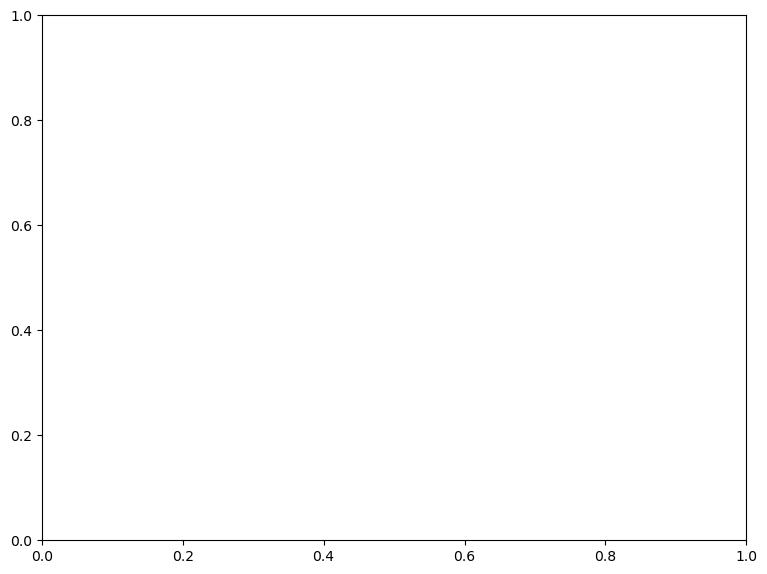

In [17]:
def visualize_response_trends(benchmark_df, metric_name, n_groups=3):
    """
    Create visual analysis of response trends with plots and formatted tables
    """
    # Create agreement groups based on std
    benchmark_df['agreement_level'] = pd.qcut(benchmark_df['std'], n_groups, 
                                            labels=['High', 'Medium', 'Low'])
    
    pred_cols = [col for col in benchmark_df.columns if col.startswith('predicted_text_')]
    metric_cols = [col for col in benchmark_df.columns if col.startswith(metric_name + '_')]
    
    # Set up the plotting style
    plt.style.use('default')  # Use default style instead of seaborn
    fig = plt.figure(figsize=(20, 15))  # Increased figure size
    
    # 1. Response Length Distribution Plot
    plt.subplot(2, 2, 1)
    data_for_box = []
    for level in ['High', 'Medium', 'Low']:
        level_df = benchmark_df[benchmark_df['agreement_level'] == level]
        for col in pred_cols:
            lengths = level_df[col].apply(lambda x: len(str(x).split()))
            data_for_box.append(lengths.values)
    
    plt.boxplot(data_for_box, labels=['High', 'Medium', 'Low'])
    plt.title('Response Length Distribution\nby Agreement Level', fontsize=12, pad=20)
    plt.ylabel('Number of Words', fontsize=10)
    plt.xlabel('Agreement Level', fontsize=10)
    
    # 2. Metric Scores Distribution
    plt.subplot(2, 2, 2)
    for level in ['High', 'Medium', 'Low']:
        level_df = benchmark_df[benchmark_df['agreement_level'] == level]
        scores = level_df[metric_cols].mean(axis=1)
        plt.hist(scores, alpha=0.5, label=level, bins=20)
    
    plt.title(f'{metric_name}\nDistribution by Agreement Level', fontsize=12, pad=20)
    plt.xlabel('Score', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend()
    
    # 3. Question Length vs Agreement
    plt.subplot(2, 2, 3)
    question_lengths = benchmark_df['input.text'].apply(len)
    plt.scatter(question_lengths, benchmark_df['std'], alpha=0.5, s=50)
    plt.title('Question Length vs Agreement Level', fontsize=12, pad=20)
    plt.xlabel('Question Length (characters)', fontsize=10)
    plt.ylabel('Standard Deviation\n(lower = higher agreement)', fontsize=10)
    
    # 4. Agreement Level Distribution
    plt.subplot(2, 2, 4)
    counts = benchmark_df['agreement_level'].value_counts()
    plt.bar(range(len(counts)), counts.values)
    plt.xticks(range(len(counts)), counts.index, rotation=0)
    plt.title('Distribution of Agreement Levels', fontsize=12, pad=20)
    plt.xlabel('Agreement Level', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Create summary tables (rest of the code remains the same)
    print("\n=== Summary Statistics ===")
    
    # Summary table for each agreement level
    summary_data = []
    for level in ['High', 'Medium', 'Low']:
        level_df = benchmark_df[benchmark_df['agreement_level'] == level]
        
        # Calculate statistics
        avg_length = level_df[pred_cols].applymap(lambda x: len(str(x).split())).mean().mean()
        avg_score = level_df[metric_cols].mean().mean()
        n_questions = len(level_df)
        std_range = (level_df['std'].min(), level_df['std'].max())
        
        summary_data.append([
            level, n_questions, f"{avg_length:.1f}", f"{avg_score:.3f}",
            f"{std_range[0]:.3f} - {std_range[1]:.3f}"
        ])
    
    print("\n" + tabulate(summary_data, 
                         headers=['Agreement', 'N Questions', 'Avg Length', f'Avg {metric_name}', 'Std Range'],
                         tablefmt='grid'))
    
    # Sample responses table with improved formatting
    print("\n=== Sample Questions and Responses ===")
    sample_data = []
    for level in ['High', 'Medium', 'Low']:
        level_df = benchmark_df[benchmark_df['agreement_level'] == level]
        # Get the row with median std for more representative samples
        median_idx = level_df['std'].abs().sort_values().index[len(level_df)//2]
        sample_row = level_df.loc[median_idx]
        
        responses = [sample_row[col] for col in pred_cols[:3]]
        response_text = ' | '.join(str(r) for r in responses)
        
        sample_data.append([
            level,
            sample_row['input.text'][:100] + '...' if len(sample_row['input.text']) > 100 else sample_row['input.text'],
            response_text
        ])
    
    print("\n" + tabulate(sample_data,
                         headers=['Agreement', 'Question', 'Model Responses (first 3)'],
                         tablefmt='grid',
                         maxcolwidths=[10, 50, 50]))

# Run the visualization for each benchmark
for benchmark, ranked_df in ranked_results.items():
    print(f"\n\nAnalyzing benchmark: {benchmark}")
    print("=" * 80)
    
    metric_name = None
    for possible_metric in metrics.keys():
        if any(col.startswith(possible_metric) for col in ranked_df.columns):
            metric_name = possible_metric
            break
    
    if metric_name:
        visualize_response_trends(ranked_df, metric_name)
    
    break